<a href="https://colab.research.google.com/github/edgarbarr1/colon-cancer-cnn/blob/main/colon_cancer_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colon Cancer #
### _Predicting the outcomes of colon cells to predict cancer_ ###

### Business Understanding ###
Colon cancer has been deemed the number 3 most common cancer in the world, according to the World Cancer Research Fund. Based on this statistic, it is not a surprise to know that more approximately 19 million colonoscopies are perfeormed each year in the United States.

Some experts believe that some of the main causes of this cancer is the Western food diet along with living a sedentary lifestyle as well as being obese. Unfortunately, according to the CDC, the US appears to be on an upward trend in obesity which in turn increses the likelihood of men and women to develop colorectal cancers.

Although the morttality rate for the most part appears to be relatively low (80% survival rate), it is important to note that like everything, there is always something to improve with either accurate test results, the time it takes to report those results and the resources available to compile said results.

Currently, as per the American Cancer Society, it takes 2-3 days to report the findings of a colonoscopy biopsy.

Objective
This notebook has the objective of finding out the population that is deeply affected by colon cancer and build a Convolutional Neural Network that can get close to the 1-2% accuracy that current tests. We will also strive to have an efficient model that can give accurate results faster than 2-3 days and ideally within the time frame of "same-day" results.

Before doing so, we will look at some mortality rates among different populations and determine whether the economic status of a population affects the mortality rate of colon cancer.



In [40]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random

import PIL
import PIL.Image
import pathlib
# Packages to import and preprocess images
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

# Packages for our models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dropout
import seaborn as sns

# Model performance
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

%matplotlib inline

In [15]:
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
print(tf.__version__)

2.6.0


# Standard global variables

In [177]:
EPOCHS = 15
BATCH_SIZE = 20
IMAGE_SIZE = (224,224)

paths_to_jpeg = ['/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/TUM',
                 '/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/NORM']

separated_dirs = ['/content/drive/MyDrive/colon_dataset/train/normal',
                  '/content/drive/MyDrive/colon_dataset/train/cancer',
                  '/content/drive/MyDrive/colon_dataset/validation/cancer',
                  '/content/drive/MyDrive/colon_dataset/validation/normal',
                  '/content/drive/MyDrive/colon_dataset/test/normal',
                  '/content/drive/MyDrive/colon_dataset/test/cancer']



# Defining our Functions


### Converting images from Tif to Jpeg

In [18]:
def tif_to_jpeg(specified_path):
  '''
  Converts tif images to jpegs from specified path.
  '''
  for path in specified_path:
    for root, dirs, files in os.walk(path, topdown=False,):
      for name in files:
          print(os.path.join(root, name))
          if os.path.splitext(os.path.join(root, name))[1].lower() == ".tiff":
            if os.path.splitext(os.path.join(root, name))[1].lower() == ".tif":
              if os.path.isfile(os.path.splitext(os.path.join(root, name))[0] + ".jpg"):
                  print ("A jpeg file already exists for %s" % name)
              # If a jpeg with the name does *NOT* exist, convert one from the tif.
              else:
                  outputfile = os.path.splitext(os.path.join(root, name))[0] + ".jpg"
                  try:
                      im = PIL.Image.open(os.path.join(root, name))
                      print ("Converting jpeg for %s" % name)
                      im.thumbnail(im.size)
                      im.save(outputfile, "JPEG", quality=100)
                  except Exception as e: 
                    print(e)

### Separating our files ###

In [19]:
def file_separation(directory_name):
  '''
  Subdirectory creation and file separation for the training, validation and testing subdirectories.
  '''

  for dir in directory_name:
    if os.path.isdir(dir) is False:
      os.makedirs(dir)

  for image in random.sample(glob.glob('{}/*.jpg'.format(directory_name[0])), 8000):
    shutil.move(image, '/content/drive/MyDrive/colon_dataset/train/cancer/') # make sure to put the correct path you want it to direct to
  for image in random.sample(glob.glob('{}/*.jpg'.format(directory_name[1])), 8000):
    shutil.move(image, '/content/drive/MyDrive/colon_dataset/train/normal/') # make sure to put the correct path you want it to direct to
  for image in random.sample(glob.glob('{}/*.jpg'.format(directory_name[0])), 400):
    shutil.move(image, '/content/drive/MyDrive/colon_dataset/validation/cancer/') # make sure to put the correct path you want it to direct to
  for image in random.sample(glob.glob('{}/*.jpg'.format(directory_name[1])), 400):
    shutil.move(image, '/content/drive/MyDrive/colon_dataset/validation/normal/') # make sure to put the correct path you want it to direct to
  for image in random.sample(glob.glob('{}/*.jpg'.format(directory_name[0])), 360):
      shutil.move(image, '/content/drive/MyDrive/colon_dataset/test/cancer') # make sure to put the correct path you want it to direct to
  for image in random.sample(glob.glob('{}/*.jpg'.format(directory_name[1])), 360):
    shutil.move(image, '/content/drive/MyDrive/colon_dataset/test/normal') # make sure to put the correct path you want it to direct to

Deleted all folders from zenodo except NORM which is normal and TUM which is the cancer cells

Inspiration for the function in the creation of the [directories](https://www.youtube.com/watch?v=_L2uYfVV48I)

In order to have class balance in the dataset we will be using a total of 24,000 images for our model training, 1,800 items for the validation, and 1,720 images for our test dataset to generate predictions. This brings our total of images used to 27,520 images used in this Convolutional Neural Network.

In [20]:
# os.listdir()

In [21]:
# PIL.Image.open('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/NORM/NORM-AAAKGLVQ.tif')

In [22]:
# normal_image_count = len(list(glob.glob('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/NORM/*.tif')))
# cancer_image_count = len(list(glob.glob('/content/drive/MyDrive/colon_dataset/NCT-CRC-HE-100K/TUM/*.tif')))
# print('Normal images: {}'.format(normal_image_count))
# print('Cancer images: {}'.format(cancer_image_count))

# Defining Visualization functions

### Confusion Matrix Visualization

In [23]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred,)
    
    ax= plt.subplot()
    # annot=True to annotate cells, fmt='g' to disable scientific notation
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='magma', linewidths=1, linecolor='black')

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['NORMAL', 'CANCER'])
    ax.yaxis.set_ticklabels(['NORMAL', 'CANCER'])
    plt.show();

### Training Visualizations

In [24]:
def visualize_training_results_1(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['recall'])
    ax1.plot(history.history['val_recall'])
    ax1.set_ylabel('Recall')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    ax3.plot(history.history['precision'])
    ax3.plot(history.history['val_precision'])
    ax3.set_ylabel('Precision')
    ax3.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()
    pass



def visualize_training_results(history, iteration):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['recall_{}'.format(iteration)])
    ax1.plot(history.history['val_recall_{}'.format(iteration)])
    ax1.set_ylabel('Recall')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    ax3.plot(history.history['precision_{}'.format(iteration)])
    ax3.plot(history.history['val_precision_{}'.format(iteration)])
    ax3.set_ylabel('Precision')
    ax3.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()
    pass

# Let's convert our images to jpegs

The images in the dataset are in TIF format. Let's convert the images into jpegs. We have fortunately already defined a function to do so.

In [25]:
#tif_to_jpeg(paths_to_jpeg)

# Jpegs have been converted. Now separate into subdirectories.

Now let's divide the images into subdirectories.
Currently we have tif and jpeg duplicates in our directory. Now we will move the jpeg images to the newly created directories.

In [26]:
# file_separation(separated_dirs)

# Image Data Generator #

Let's create an Image Generator to augment our training data and a separate generator for our validation data.

In [34]:
# Image augmentator for training data
data_gen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = (0.85,1),
    brightness_range = [0.5, 1.0],
    horizontal_flip = True,
    rotation_range = 45
)

# Image Data generator for the validation data
valid_data_gen = ImageDataGenerator(
    rescale = 1./255
)

test_gen = ImageDataGenerator(
    rescale = 1./255
)

In [35]:
# Generator that creates training data
train_generator = data_gen.flow_from_directory(
    '/content/drive/MyDrive/colon_dataset/train',
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = 'binary',
    seed = 20
)

# Generator that creates the validation generator
validation_generator = valid_data_gen.flow_from_directory(
    '/content/drive/MyDrive/colon_dataset/validation',
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = 'binary',
    seed = 20
)

# Evaluation Generator to create predictions and evaluate a model from training data
eval_train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    '/content/drive/MyDrive/colon_dataset/train',
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = 'binary',
    seed = 21
)

# Evaluation Generator to create predictions and evaluate a model from validation data
eval_validation_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    '/content/drive/MyDrive/colon_dataset/validation',
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = 'binary',
    seed = 21
)

holdout_data = test_gen.flow_from_directory(
    '/content/drive/MyDrive/colon_dataset/test',
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = 'binary',
    seed = 21
)

Found 16000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 720 images belonging to 2 classes.


Our amount of images checks out based on how many images were ported over to the proper subdirectory.

# DataFrame to Save Model results

We will instantiate a DataFrame to save our model results to and then compare the metrics between the models.

In [36]:
performance_df = pd.DataFrame()

# Definining Callbacks

In order to save time and gather the best model results, we will define some callbacks such as early stop, which will stop a model after 3 epochs of no imporvement in our validation loss. We will also instantiate our Model Checkpoint that will monitor our validation loss and will save our best weights.

In [37]:
early_stop = EarlyStopping(monitor='val_loss', patience=2,
                           mode='auto')
checkpoint = ModelCheckpoint('/content/drive/MyDrive/colon_dataset/checkpoint',
                             monitor='val_loss',
                             verbose = 1,
                             save_best_only=True)

# Baseline Model

Let's create our first model based on the data generator that we created above.

Our first model will be a rather simple one with the following layers:




1.   A convolutional layer with a (2,2) kernel size or the height and width of our convolutional window.
2.   A Max Pooling Layer that with a height and width of (2,2).
1.   A Dense Layer with a 32 output size
2.   Finally a Dense Layer with a 1 output size and a sigmoid activation function.










In [38]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2,2), activation='relu', padding='same', input_shape = (224,224,3)))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                12845088  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,845,537
Trainable params: 12,845,537
Non-trainable params: 0
_________________________________________________________________


We will be evaluating our model's performance by using Precision, Recall, and Accuracy. Though, we will be paying close attention to Recall because we want the highest amount of true positives and false negatives in our results.

In [41]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall(), 'accuracy'])

In [42]:
start = time.time()
history = model.fit(x = train_generator,
                    validation_data = validation_generator,
                    epochs = EPOCHS,
                    steps_per_epoch = 50,
                    callbacks = [early_stop,checkpoint])
end = time.time()
model_time = end - start # get time it took our model to run/train

Epoch 1/15
50/50 [==============================] - 466s 9s/step - loss: 0.9519 - precision: 0.5553 - recall: 0.5318 - accuracy: 0.5780 - val_loss: 1.1605 - val_precision: 0.5019 - val_recall: 1.0000 - val_accuracy: 0.5038

Epoch 00001: val_loss improved from inf to 1.16046, saving model to /content/drive/MyDrive/colon_dataset/checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint/assets
Epoch 2/15
50/50 [==============================] - 240s 5s/step - loss: 0.7136 - precision: 0.5547 - recall: 0.6178 - accuracy: 0.5750 - val_loss: 0.6698 - val_precision: 0.8986 - val_recall: 0.1550 - val_accuracy: 0.5688

Epoch 00002: val_loss improved from 1.16046 to 0.66982, saving model to /content/drive/MyDrive/colon_dataset/checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint/assets
Epoch 3/15
50/50 [==============================] - 225s 5s/step - loss: 0.6650 - precision: 0.5670 - recall: 0.8772 - accuracy: 0.5870 

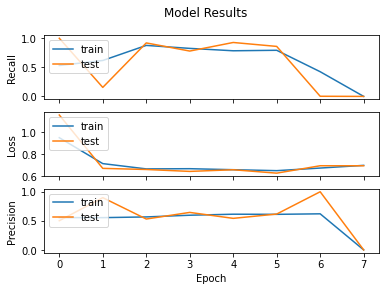

In [43]:
visualize_training_results_1(history)

In [47]:
train_model_metrics = model.evaluate(eval_train_generator, verbose=1)
train_model_metrics

800/800 [==============================] - 45s 56ms/step - loss: 0.6938 - precision: 0.6000 - recall: 3.7500e-04 - accuracy: 0.5001


In [49]:
val_model_metrics = model.evaluate(eval_validation_generator,verbose=1)
val_model_metrics

40/40 [==============================] - 2s 55ms/step - loss: 0.6938 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.5000


It does not appear as though our model learned much from the images, though that is to be expected as it is a very simple model and does not learn much from the images.

Let's save these results.

In [73]:
performance_df = pd.DataFrame(columns=['model', 'loss', 'precision', 'recall', 'accuracy'])
performance_df.loc[len(performance_df.index)] = ['model_train'] + train_model_metrics
performance_df.loc[len(performance_df.index)] = ['model_valid'] + val_model_metrics
performance_df.head()

,model,loss,precision,recall,accuracy
0,model_train,0.693813,0.6,0.000375,0.500063
1,model_valid,0.693824,0.0,0.000000,0.500000


In [74]:
performance_df['time_to_train'] = model_time

In [90]:
performance_df.head()

,model,loss,precision,recall,accuracy,time_to_train,time_to_predict
0,model_train,0.693813,0.6,0.000375,0.500063,1926.035368,44.777210
1,model_valid,0.693824,0.0,0.000000,0.500000,1926.035368,2.325076


In [91]:
training_start = time.time()
preds_train_1 = model.predict(eval_train_generator, verbose=1)
training_end = time.time()

validation_start = time.time()
preds_val_1 = model.predict(eval_validation_generator, verbose = 1)
validation_end = time.time()

training_time = training_end - training_start
validation_time = validation_end - validation_start

40/40 [==============================] - 2s 55ms/step


In [93]:
performance_df.at[0,'time_to_predict'] = training_time
performance_df.at[1,'time_to_predict'] = validation_time
performance_df

,model,loss,precision,recall,accuracy,time_to_train,time_to_predict
0,model_train,0.693813,0.6,0.000375,0.500063,1926.035368,44.241322
1,model_valid,0.693824,0.0,0.000000,0.500000,1926.035368,2.285456


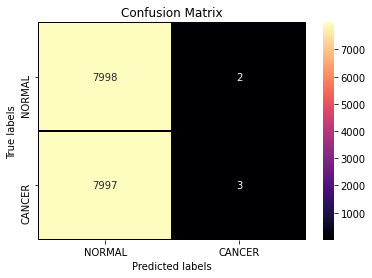

In [94]:
plot_confusion_matrix(eval_train_generator.labels, np.rint(preds_train_1))

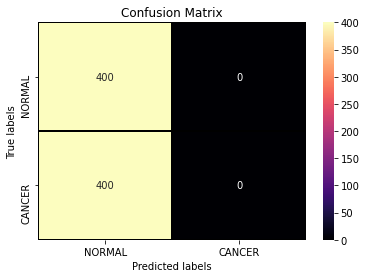

In [95]:
plot_confusion_matrix(eval_validation_generator.labels, np.rint(preds_val_1))

As per the confusion matrix above, the model appears to be predicting, for the most part, NORMAL values only. This can be attributed to the fact that we have a very shallow Neural Network that is not able to pickup the very fine details of the images and therefore attributing every image as NORMAL.

In [96]:
# performance_df.to_csv('/content/drive/MyDrive/colon_dataset/performance.csv')

# Model 2 #

We will be adding to our first baseline model by adding more convolutional layers and one more MaxPooling Layer. We will also add one more Dense layer using LeakyReLU as the activation function.

In [97]:
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(2,2), padding='valid', input_shape = (224,224,3)))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, kernel_size=(2,2), padding='same', activation='relu'))
model_2.add(Conv2D(32, kernel_size=(2,2), padding='same', activation='relu'))
model_2.add(MaxPooling2D(2,2))
model_2.add(Flatten())
model_2.add(Dense(128, activation=LeakyReLU(alpha=(.3))))
model_2.add(Dropout(.20))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [98]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 32)      416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 32)      4128      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 111, 32)      4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [100]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall(), 'accuracy'])

In [101]:
start = time.time()
history_2 = model_2.fit(
    x = train_generator,
    validation_data = validation_generator,
    epochs = 15,
    callbacks = [checkpoint,early_stop]
)
end = time.time()

model_2_train_time = end - start

Epoch 1/15
800/800 [==============================] - 210s 261ms/step - loss: 0.4406 - precision_1: 0.7775 - recall_1: 0.8305 - accuracy: 0.7964 - val_loss: 0.7701 - val_precision_1: 0.9793 - val_recall_1: 0.4725 - val_accuracy: 0.7312

Epoch 00001: val_loss did not improve from 0.62591
Epoch 2/15
800/800 [==============================] - 210s 262ms/step - loss: 0.3107 - precision_1: 0.8492 - recall_1: 0.8951 - accuracy: 0.8681 - val_loss: 0.2757 - val_precision_1: 0.8551 - val_recall_1: 0.8850 - val_accuracy: 0.8675

Epoch 00002: val_loss improved from 0.62591 to 0.27574, saving model to /content/drive/MyDrive/colon_dataset/checkpoint


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint/assets


Epoch 3/15
800/800 [==============================] - 211s 264ms/step - loss: 0.2436 - precision_1: 0.8850 - recall_1: 0.9165 - accuracy: 0.8987 - val_loss: 0.7645 - val_precision_1: 0.9867 - val_recall_1: 0.5575 - val_accuracy: 0.7750

Epoch 00003: val_loss did not improve from 0.27574
Epoch 4/15
800/800 [==============================] - 210s 263ms/step - loss: 0.2171 - precision_1: 0.9012 - recall_1: 0.9309 - accuracy: 0.9144 - val_loss: 0.3066 - val_precision_1: 0.9759 - val_recall_1: 0.7100 - val_accuracy: 0.8462

Epoch 00004: val_loss did not improve from 0.27574


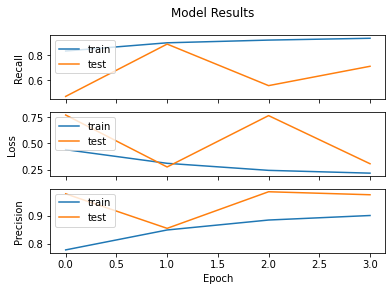

In [149]:
visualize_training_results(history_2, 1)

In [102]:
model_metrics_train = model_2.evaluate(eval_train_generator, verbose=1)
model_metrics_train
model_metrics_val = model_2.evaluate(eval_validation_generator,verbose=1)
model_metrics_train

40/40 [==============================] - 2s 55ms/step - loss: 0.3066 - precision_1: 0.9759 - recall_1: 0.7100 - accuracy: 0.8462


[0.31216686964035034,
 0.9780656099319458,
 0.7078750133514404,
 0.8460000157356262]

In [103]:
model_two_start_train = time.time()
preds_train_2 = model_2.predict(eval_train_generator)
model_two_end_train = time.time()

model_two_start_val = time.time()
preds_val_2 = model_2.predict(eval_validation_generator)
model_two_end_val = time.time()

model_two_train_time = model_two_end_train - model_two_start_train
model_two_val_time = model_two_end_val - model_two_start_val

In [161]:
performance_df.at[2,'model'] = 'model_two_train'
performance_df.at[2,'loss'] = model_metrics_train[0]
performance_df.at[2,'precision'] = model_metrics_train[1]
performance_df.at[2, 'recall'] = model_metrics_train[2]
performance_df.at[2,'accuracy'] = model_metrics_train[3]
performance_df.at[2,'time_to_train'] = model_2_train_time
performance_df.at[2,'time_to_predict'] = model_two_train_time

In [162]:
performance_df.at[3,'model'] = 'model_two_val'
performance_df.at[3,'loss'] = model_metrics_val[0]
performance_df.at[3,'precision'] = model_metrics_val[1]
performance_df.at[3, 'recall'] = model_metrics_val[2]
performance_df.at[3,'accuracy'] = model_metrics_val[3]
performance_df.at[3,'time_to_train'] = model_2_train_time
performance_df.at[3,'time_to_predict'] = model_two_val_time

In [163]:
performance_df

,model,loss,precision,recall,accuracy,time_to_train,time_to_predict
0,model_train,0.693813,0.600000,0.000375,0.500063,1926.035368,44.241322
1,model_val,0.693824,0.000000,0.000000,0.500000,1926.035368,2.285456
2,model_two_train,0.312167,0.978066,0.707875,0.846000,842.737414,41.175385
3,model_two_val,0.306575,0.975945,0.710000,0.846250,842.737414,2.193514


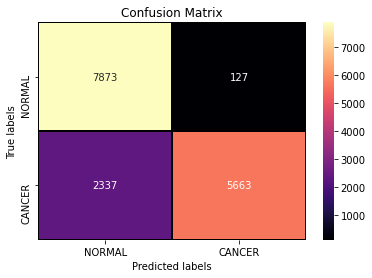

In [147]:
plot_confusion_matrix(eval_train_generator.labels, np.rint(preds_train_2))

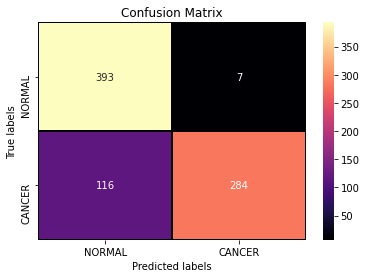

In [148]:
plot_confusion_matrix(eval_validation_generator.labels, np.rint(preds_val_2))

We can See that we are not getting amazing results on the model as we have alot of Normal cells being predicted correctly while having a higher margin of error in the prediction of cancer cells which we certainly don't want.

# Model 3 #

In [150]:
model_3 = Sequential()
model_3.add(Conv2D(32, kernel_size=(2,2), activation='relu',padding='valid', input_shape = (224,224,3)))
model_3.add(Conv2D(32, kernel_size=(2,2), activation='relu', padding='valid'))
model_3.add(Conv2D(64, kernel_size=(2,2), padding='same', activation=LeakyReLU()))
model_3.add(MaxPooling2D(3,3))
model_3.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model_3.add(Conv2D(64, kernel_size=(3,3), padding='same', activation=LeakyReLU()))
model_3.add(MaxPooling2D(2,2))
model_3.add(Conv2D(64, kernel_size=(3,3), activation=LeakyReLU(), padding='valid'))
model_3.add(Flatten())
model_3.add(Dense(64,activation='relu'))
model_3.add(Dense(64, activation=LeakyReLU()))
model_3.add(Dropout(.20))
model_3.add(Dense(64,activation='relu'))
model_3.add(Dense(64, activation=LeakyReLU()))
model_3.add(Dense(1, activation='sigmoid'))

In [151]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 223, 223, 32)      416       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 222, 222, 32)      4128      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 222, 222, 64)      8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 74, 74, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 74, 74, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)       

In [152]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall(), 'accuracy'])

In [153]:
model_three_start = time.time()
history_3 = model_3.fit(x=train_generator,
            validation_data = validation_generator,
            epochs=15,
            callbacks = [early_stop,checkpoint])
model_three_end = time.time()

time_to_train_three = model_three_end - model_three_start

Epoch 1/15
800/800 [==============================] - 212s 263ms/step - loss: 0.6946 - precision_2: 0.5036 - recall_2: 0.4509 - accuracy: 0.5032 - val_loss: 0.6963 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.5000

Epoch 00001: val_loss did not improve from 0.27574
Epoch 2/15
800/800 [==============================] - 210s 263ms/step - loss: 0.6939 - precision_2: 0.4995 - recall_2: 0.4366 - accuracy: 0.4996 - val_loss: 0.6932 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.27574
Epoch 3/15
800/800 [==============================] - 211s 263ms/step - loss: 0.6933 - precision_2: 0.4996 - recall_2: 0.6211 - accuracy: 0.4995 - val_loss: 0.6932 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.27574
Epoch 4/15
800/800 [==============================] - 209s 262ms/step - loss: 0.6933 - precision_2: 0.4921 - rec

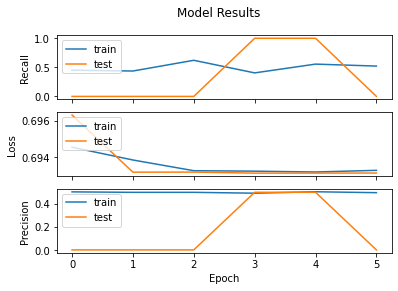

In [154]:
visualize_training_results(history_3, 2)

In [155]:
model_metrics_3 = model_3.evaluate(eval_train_generator)
model_metrics_3

800/800 [==============================] - 44s 55ms/step - loss: 0.6932 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - accuracy: 0.5000


[0.6931617856025696, 0.0, 0.0, 0.5]

In [168]:
model_three_start_train = time.time()
preds_train_3 = model_3.predict(eval_train_generator)
model_three_end_train = time.time()

model_three_start_val = time.time()
preds_val_3 = model_3.predict(eval_validation_generator)
model_three_end_val = time.time()

model_three_train_time = model_three_end_train - model_three_start_train
model_three_val_time = model_three_end_val - model_three_start_val

In [169]:
performance_df.at[4,'model'] = 'model_three_train'
performance_df.at[4,'loss'] = model_metrics_3[0]
performance_df.at[4,'precision'] = model_metrics_3[1]
performance_df.at[4, 'recall'] = model_metrics_3[2]
performance_df.at[4,'accuracy'] = model_metrics_3[3]
performance_df.at[4,'time_to_train'] = time_to_train_three
performance_df.at[4,'time_to_predict'] = model_three_train_time

In [170]:
performance_df.at[5,'model'] = 'model_three_val'
performance_df.at[5,'loss'] = model_metrics_3[0]
performance_df.at[5,'precision'] = model_metrics_3[1]
performance_df.at[5, 'recall'] = model_metrics_3[2]
performance_df.at[5,'accuracy'] = model_metrics_3[3]
performance_df.at[5,'time_to_train'] = time_to_train_three
performance_df.at[5,'time_to_predict'] = model_three_val_time

In [171]:
performance_df

,model,loss,precision,recall,accuracy,time_to_train,time_to_predict
0,model_train,0.693813,0.600000,0.000375,0.500063,1926.035368,44.241322
1,model_val,0.693824,0.000000,0.000000,0.500000,1926.035368,2.285456
2,model_two_train,0.312167,0.978066,0.707875,0.846000,842.737414,41.175385
3,model_two_val,0.306575,0.975945,0.710000,0.846250,842.737414,2.193514
4,model_three_train,0.693162,0.000000,0.000000,0.500000,1260.386662,39.929324
5,model_three_val,0.693162,0.000000,0.000000,0.500000,1260.386662,2.086205


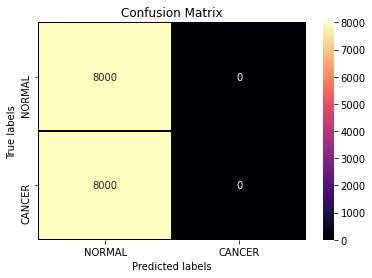

In [172]:
plot_confusion_matrix(eval_train_generator.labels, np.rint(preds_train_3))

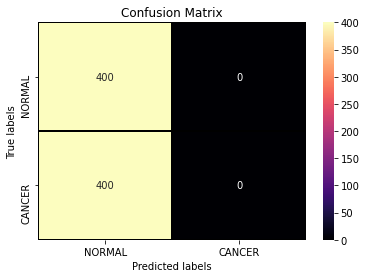

In [173]:
plot_confusion_matrix(eval_validation_generator.labels, np.rint(preds_val_3))

We are still seeing the same problem with predicting only one class and getting only 50% of those predictions right. Let's now try some transfer learning to see if we can get better results.

# ResNet

In [176]:
from tensorflow.keras.applications import ResNet50

In [178]:
resnet_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/drive/MyDrive/colon_dataset/train',
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = 'binary',
    seed = 20
)
resnet_val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/drive/MyDrive/colon_dataset/validation',
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = 'binary',
    seed = 20
)

Found 16000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [179]:
model_4 = Sequential()

resnet_model = ResNet50(weights = 'imagenet',
                        include_top = False,
                        pooling= 'avg')

model_4.add(resnet_model)
model_4.add(Dense(1, activation='sigmoid'))
for layer in resnet_model.layers:
  layer.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [181]:
from tensorflow.keras.optimizers import SGD

In [182]:
sgd = SGD(learning_rate=0.001)
model_4.compile(optimizer=sgd,loss='binary_crossentropy',metrics = [Precision(),Recall(), 'accuracy'])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [183]:
history_resnet = model_4.fit(x = resnet_gen,
                             validation_data = resnet_val_gen,
                             steps_per_epoch = (resnet_gen.n//20),
                             validation_steps = (resnet_val_gen.n//20),
                             epochs = 5,
                             callbacks = checkpoint)

Epoch 1/5
800/800 [==============================] - 54s 64ms/step - loss: 0.6769 - precision_3: 0.5838 - recall_3: 0.5799 - accuracy: 0.5832 - val_loss: 0.6549 - val_precision_3: 0.7029 - val_recall_3: 0.6150 - val_accuracy: 0.6775

Epoch 00001: val_loss did not improve from 0.27574
Epoch 2/5
800/800 [==============================] - 50s 63ms/step - loss: 0.6470 - precision_3: 0.6522 - recall_3: 0.6202 - accuracy: 0.6447 - val_loss: 0.6325 - val_precision_3: 0.7622 - val_recall_3: 0.5850 - val_accuracy: 0.7013

Epoch 00002: val_loss did not improve from 0.27574
Epoch 3/5
800/800 [==============================] - 51s 64ms/step - loss: 0.6289 - precision_3: 0.6848 - recall_3: 0.6267 - accuracy: 0.6691 - val_loss: 0.6254 - val_precision_3: 0.8593 - val_recall_3: 0.4275 - val_accuracy: 0.6787

Epoch 00003: val_loss did not improve from 0.27574
Epoch 4/5
800/800 [==============================] - 51s 64ms/step - loss: 0.6170 - precision_3: 0.6969 - recall_3: 0.6249 - accuracy: 0.6766 - v

In [184]:
for layer in resnet_model.layers:
  layer.trainable = True

In [185]:
sgd = SGD(learning_rate=0.01)

model_4.compile(optimizer=sgd,
                loss = 'binary_crossentropy',
                metrics = [Precision(), Recall(), 'accuracy'])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [186]:
resnet_start = time.time()
history_resnet_unfrozen = model_4.fit(x = resnet_gen,
                                      validation_data = resnet_val_gen,
                                      epochs = 15,
                                      steps_per_epoch = (resnet_gen.n//20),
                                      validation_steps = (resnet_val_gen.n//20),
                                      callbacks = checkpoint)
resnet_end = time.time()

resnet_train_time = resnet_end - resnet_start

Epoch 1/15
800/800 [==============================] - 106s 127ms/step - loss: 0.0770 - precision_4: 0.9712 - recall_4: 0.9696 - accuracy: 0.9704 - val_loss: 1.3059 - val_precision_4: 0.5089 - val_recall_4: 1.0000 - val_accuracy: 0.5175

Epoch 00001: val_loss did not improve from 0.27574
Epoch 2/15
800/800 [==============================] - 101s 126ms/step - loss: 0.0216 - precision_4: 0.9934 - recall_4: 0.9925 - accuracy: 0.9929 - val_loss: 0.0428 - val_precision_4: 0.9974 - val_recall_4: 0.9650 - val_accuracy: 0.9812

Epoch 00002: val_loss improved from 0.27574 to 0.04278, saving model to /content/drive/MyDrive/colon_dataset/checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
800/800 [==============================] - 101s 126ms/step - loss: 0.0133 - precision_4: 0.9958 - recall_4: 0.9961 - accuracy: 0.9959 - val_loss: 0.1209 - val_precision_4: 0.9217 - val_recall_4: 1.0000 - val_accuracy: 0.9575

Epoch 00003: val_loss did not improve from 0.04278
Epoch 4/15
800/800 [==============================] - 101s 126ms/step - loss: 0.0061 - precision_4: 0.9984 - recall_4: 0.9989 - accuracy: 0.9986 - val_loss: 0.0236 - val_precision_4: 0.9852 - val_recall_4: 1.0000 - val_accuracy: 0.9925

Epoch 00004: val_loss improved from 0.04278 to 0.02364, saving model to /content/drive/MyDrive/colon_dataset/checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/15
800/800 [==============================] - 101s 126ms/step - loss: 0.0060 - precision_4: 0.9989 - recall_4: 0.9985 - accuracy: 0.9987 - val_loss: 0.0098 - val_precision_4: 0.9975 - val_recall_4: 0.9975 - val_accuracy: 0.9975

Epoch 00005: val_loss improved from 0.02364 to 0.00976, saving model to /content/drive/MyDrive/colon_dataset/checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/15
800/800 [==============================] - 101s 126ms/step - loss: 0.0042 - precision_4: 0.9990 - recall_4: 0.9990 - accuracy: 0.9990 - val_loss: 0.0293 - val_precision_4: 0.9828 - val_recall_4: 1.0000 - val_accuracy: 0.9912

Epoch 00006: val_loss did not improve from 0.00976
Epoch 7/15
800/800 [==============================] - 101s 126ms/step - loss: 0.0029 - precision_4: 0.9991 - recall_4: 0.9996 - accuracy: 0.9994 - val_loss: 0.0231 - val_precision_4: 1.0000 - val_recall_4: 0.9875 - val_accuracy: 0.9937

Epoch 00007: val_loss did not improve from 0.00976
Epoch 8/15
800/800 [==============================] - 101s 126ms/step - loss: 0.0027 - precision_4: 0.9994 - recall_4: 0.9992 - accuracy: 0.9993 - val_loss: 0.0099 - val_precision_4: 0.9975 - val_recall_4: 0.9975 - val_accuracy: 0.9975

Epoch 00008: val_loss did not improve from 0.00976
Epoch 9/15
800/800 [==============================] - 101s 126ms/step - loss: 0.0025 - precision_4: 0.9995 - recall_4: 0.9994 - accuracy

INFO:tensorflow:Assets written to: /content/drive/MyDrive/colon_dataset/checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/15
800/800 [==============================] - 101s 126ms/step - loss: 0.0017 - precision_4: 0.9996 - recall_4: 0.9999 - accuracy: 0.9998 - val_loss: 0.0095 - val_precision_4: 0.9975 - val_recall_4: 0.9975 - val_accuracy: 0.9975

Epoch 00012: val_loss did not improve from 0.00828
Epoch 13/15
800/800 [==============================] - 101s 126ms/step - loss: 7.6946e-04 - precision_4: 1.0000 - recall_4: 1.0000 - accuracy: 1.0000 - val_loss: 0.0104 - val_precision_4: 0.9950 - val_recall_4: 0.9975 - val_accuracy: 0.9962

Epoch 00013: val_loss did not improve from 0.00828
Epoch 14/15
800/800 [==============================] - 101s 126ms/step - loss: 7.9704e-04 - precision_4: 1.0000 - recall_4: 0.9999 - accuracy: 0.9999 - val_loss: 0.0158 - val_precision_4: 0.9975 - val_recall_4: 0.9950 - val_accuracy: 0.9962

Epoch 00014: val_loss did not improve from 0.00828
Epoch 15/15
800/800 [==============================] - 101s 126ms/step - loss: 6.8885e-04 - precision_4: 0.9998 - recall_4: 1

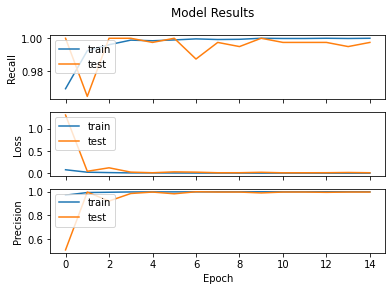

In [187]:
visualize_training_results(history_resnet_unfrozen, 4)

In [188]:
resnet_train_eval_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    '/content/drive/MyDrive/colon_dataset/train',
    color_mode='rgb',    # 3 channels
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE,
    seed=20,
    shuffle=False
)
resnet_validation_eval_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    '/content/drive/MyDrive/colon_dataset/validation',
    color_mode='rgb',    # 3 channels
    target_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE,
    seed=20,
    shuffle=False   
)

Found 16000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [189]:
resnet_prediction_start = time.time()
preds_train_resnet = model_4.predict(resnet_train_eval_generator, verbose=1)
resnet_prediction_end = time.time()

resnet_val_pred_start = time.time()
preds_val_resnet = model_4.predict(resnet_validation_eval_generator, verbose=1)
resnet_val_pred_end = time.time()

train_time_resnet = resnet_prediction_end - resnet_prediction_start
val_time_resnet = resnet_val_pred_end - resnet_val_pred_start

40/40 [==============================] - 2s 55ms/step


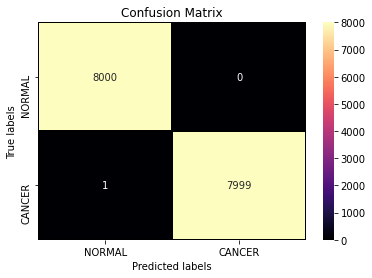

In [190]:
plot_confusion_matrix(resnet_train_eval_generator.labels, np.rint(preds_train_resnet))

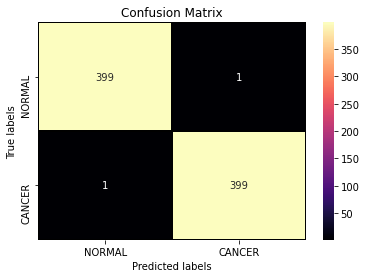

In [191]:
plot_confusion_matrix(resnet_validation_eval_generator.labels, np.rint(preds_val_resnet))

Great results. Out of the 16,800 images only 3 were predicted incorrectly. We still need to verify the results with out holdout data.